# Sentiment analysis

In [54]:
import urllib.request
import csv
import re
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load graph:
S = pickle.load(open("graph.pkl", "rb"))
DOWNLOADS_DIR = "downloads"

In [55]:
# Download the LabMT wordlist (with happiness scores)
file_id = "1fEW8gxKEfwiNRgpeqQ1S9qbATyrNftoE"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
local_filename = "labmt_wordlist.txt"
urllib.request.urlretrieve(url, local_filename)

('labmt_wordlist.txt', <http.client.HTTPMessage at 0x1866a9d5a10>)

In [56]:
# This function reads the wordlist and creates a dictionary
def load_labmt_wordlist(file_path):
    labmt_dict = {}
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        # Skip the first four lines
        for _ in range(4):
          next(reader)
        for row in reader:
            # Check if the row has the expected number of columns
            if len(row) < 3:
                print(f"Skipping row due to insufficient columns: {row}")
                continue
            word = row[0].lower()  # Lowercase the word for consistency
            try:
                score = float(row[2])  # Happiness average is in the third column
                labmt_dict[word] = score
            except ValueError:
                # Handle case where score is not a valid float
                print(f"Skipping row due to invalid score: {row}")
                continue
    return labmt_dict

In [57]:
# Load the LabMT wordlist into memory
labmt_wordlist = load_labmt_wordlist(local_filename)

# # Check to ensure the list is loaded correctly
# print(list(labmt_wordlist.items())[:10])

In [58]:
# This function will return a list of words for each philosopher's page, ready for sentiment scoring
def clean_and_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = text.split()  # Tokenize (split into words)
    return tokens

# Calculate sentiment based on the LabMT wordlist
def calculate_sentiment(tokens, labmt_dict):
    scores = [labmt_dict[word] for word in tokens if word in labmt_dict]
    return sum(scores) / len(scores) if scores else None

# Calculate the sentiment SCORE and store it as a node ATTRIBUTE
def process_graph(graph, labmt_wordlist):
    processed_count = 0  # Initialize counter for processed philosopher

    for node in graph.nodes:
        philosopher_name = node
        philosopher_file_name = philosopher_name.replace(' ', '_') + ".txt"  # Format the philosopher file name
        philosopher_file_path = os.path.join(DOWNLOADS_DIR, philosopher_file_name)  # Prepend directory path

        # Check if the file exists for this philosopher
        if os.path.exists(philosopher_file_path):
            try:
                # Read the text file content
                with open(philosopher_file_path, 'r', encoding='utf-8') as f:
                    text = f.read()

                    # Tokenize the text
                    tokens = clean_and_tokenize(text)

                    # Calculate sentiment
                    sentiment = calculate_sentiment(tokens, labmt_wordlist)

                    # Store sentiment in the graph node
                    graph.nodes[node]["sentiment"] = sentiment
                    processed_count += 1  # Increment processed count

            except Exception as e:
                print(f"Error processing file for {philosopher_name}: {e}")
        else:
            print(f"File not found for artist: {philosopher_name} ({philosopher_file_name})")

    print(f"\nTotal artists processed: {processed_count} out of {len(graph.nodes)}")


In [59]:
# Example of running the function
process_graph(S, labmt_wordlist)

# What the nodes look like now
print(list(S.nodes(data=True))[256])


Total artists processed: 1366 out of 1366
('Paul_Deussen', {'contentlength': 980, 'sentiment': 5.344014869888484})


## Some statistics

In [60]:
# Collect all valid sentiment scores from the graph
sentiment_scores = [
    S.nodes[node]["sentiment"]
    for node in S.nodes
    if S.nodes[node]["sentiment"] is not None
]

# Calculate key statistics
mean_sentiment = np.mean(sentiment_scores)
median_sentiment = np.median(sentiment_scores)
variance_sentiment = np.var(sentiment_scores)
percentile_25 = np.percentile(sentiment_scores, 25)
percentile_75 = np.percentile(sentiment_scores, 75)

# Print the statistics
print(f"Mean: {mean_sentiment:.2f}")
print(f"Median: {median_sentiment:.2f}")
print(f"Variance: {variance_sentiment:.2f}")
print(f"25th Percentile: {percentile_25:.2f}")
print(f"75th Percentile: {percentile_75:.2f}")

Mean: 5.42
Median: 5.41
Variance: 0.01
25th Percentile: 5.37
75th Percentile: 5.46


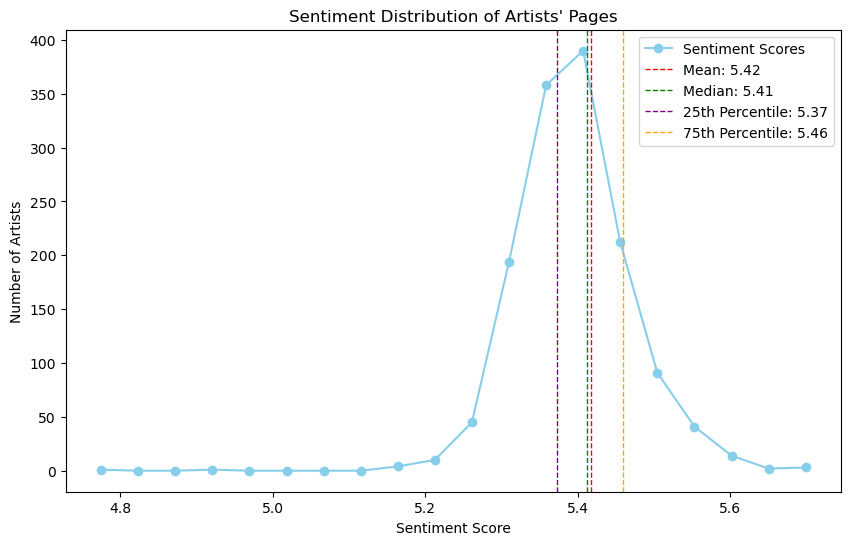

In [61]:
# A graph to represent the distribution of sentiment scores
bins = np.linspace(min(sentiment_scores), max(sentiment_scores), 21)  # 20 bins
hist_values, bin_edges = np.histogram(sentiment_scores, bins=bins)

plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist_values, marker='o', color='skyblue', linestyle='-', label="Sentiment Scores")

plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {mean_sentiment:.2f}")
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1, label=f"Median: {median_sentiment:.2f}")
plt.axvline(percentile_25, color='purple', linestyle='dashed', linewidth=1, label=f"25th Percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color='orange', linestyle='dashed', linewidth=1, label=f"75th Percentile: {percentile_75:.2f}")

plt.xlabel("Sentiment Score")
plt.ylabel("Number of Artists")
plt.title("Sentiment Distribution of Artists' Pages")
plt.legend()
plt.show()


In [62]:
# Sort nodes by sentiment score to find happiest and saddest philosophers
sorted_sentiment = sorted(
    [(node, S.nodes[node]["sentiment"]) for node in S.nodes if S.nodes[node]["sentiment"] is not None],
    key=lambda x: x[1],
    reverse=True
)

# Get the top 4 happiest and saddest philosophers
happiest_philosophes = sorted_sentiment[:4]
saddest_philosophers = sorted_sentiment[-4:]

# Print the results
print("Top 4 Happiest Philosophers:")
for artist, score in happiest_philosophes:
    print(f"{artist}: {score:.2f}")

print("\nTop 4 Saddest Philosophers:")
for artist, score in saddest_philosophers:
    print(f"{artist}: {score:.2f}")


Top 4 Happiest Philosophers:
The_Oxford_Companion_to_Philosophy: 5.75
The_Cambridge_Dictionary_of_Philosophy: 5.72
Ram_Gopal_Varma: 5.71
Richard_Schacht: 5.68

Top 4 Saddest Philosophers:
Hervaeus_Natalis: 5.19
Heinrich_Rickert: 5.17
Dietrich_of_Freiberg: 4.94
Stanislaw_Lesniewski: 4.78


## Community sentiment analysis

In [63]:
# Load the subfields partitions
subfields_partition = pickle.load(open("subfields_partition.pkl", "rb"))
tradition_partition = pickle.load(open("louvain_partition_subfields.pkl", "rb"))

# Load the tradition partitions
tradition_partition = pickle.load(open("tradition_partition.pkl", "rb"))
louvain_partition_tradition = pickle.load(open("louvain_partition_tradition.pkl", "rb"))

In [64]:
from collections import Counter

# Function to calculate the average sentiment for a specific community
def calculate_community_sentiment(graph, community_id, partition):
    community_nodes = [node for node, community in partition.items() if community == community_id]
    # Collect the pre-calculated sentiment for each node in the community
    sentiments = []
    for node in community_nodes:
      sentiment = graph.nodes[node].get("sentiment")
      if sentiment is not None:
        sentiments.append(sentiment)

    # Calculate the average sentiment for the community
    if sentiments:
      return np.mean(sentiments)
    else:
      return None

# For the partition based on SUBFIELDS
# Identify the 10 largest communities by size for focused analysis
community_sizes = Counter(subfields_partition.values())
print(community_sizes)
largest_communities1 = [community for community, _ in community_sizes.most_common(10)]
print("The 10 largest communities are:", largest_communities1)

# Calculate sentiment for each of the 10 largest communities
community_sentiments = {}
for community_id in largest_communities1:
    avg_sentiment = calculate_community_sentiment(S, community_id, subfields_partition)
    community_sentiments[community_id] = avg_sentiment
sorted_community_sentiments = sorted(community_sentiments.items(), key=lambda x: x[1], reverse=True)

print("\nCommunities sorted by average sentiment:")
for community_id, avg_sentiment in sorted_community_sentiments:
    print(f"Community {community_id}: Avg Sentiment = {avg_sentiment:.3f}")


Counter({'ethicists': 77, 'logicians': 72, 'metaphysicians': 68, 'epistemologists': 66, 'sociopolitical thinkers': 57, 'aestheticians': 51, 'critical theorists': 38, 'political philosophers': 30, 'philosophers of language': 25, 'philosophers of science': 18, 'philosophers of religion': 18, 'philosophers of mind': 17, 'feminist philosophers': 16, 'secular humanists': 14, 'political theorists': 8, 'utilitarians': 7, 'phenomenologists': 6, 'environmental philosophers': 6, 'existentialists': 1})
The 10 largest communities are: ['ethicists', 'logicians', 'metaphysicians', 'epistemologists', 'sociopolitical thinkers', 'aestheticians', 'critical theorists', 'political philosophers', 'philosophers of language', 'philosophers of science']

Communities sorted by average sentiment:
Community philosophers of language: Avg Sentiment = 5.492
Community philosophers of science: Avg Sentiment = 5.443
Community critical theorists: Avg Sentiment = 5.438
Community aestheticians: Avg Sentiment = 5.435
Comm

In [65]:
# For the partition based on TRADITION
# Identify the communities
community_sizes = Counter(tradition_partition.values())
print(community_sizes)
largest_communities2 = [community for community, _ in community_sizes.most_common(3)]
print("The communities are:", largest_communities2)

# Calculate sentiment for each of the communities
community_sentiments = {}
for community_id in largest_communities2:
    avg_sentiment = calculate_community_sentiment(S, community_id, tradition_partition)
    community_sentiments[community_id] = avg_sentiment
    print(f"Community {community_id}: Avg Sentiment = {avg_sentiment:.3f}")

Counter({'Western philosophers': 278, 'Eastern philosophers': 68})
The communities are: ['Western philosophers', 'Eastern philosophers']
Community Western philosophers: Avg Sentiment = 5.412
Community Eastern philosophers: Avg Sentiment = 5.415


We can also identify the **three most connected nodes** (philosophers) in each community of the partition based on the subfields.

In [66]:
# Get the three most connected nodes (philosophers) for each community
def get_top_connected_characters(graph, community_id, partition):
    community_nodes = [node for node, community in partition.items() if community == community_id]
    # Get degrees of nodes in the community
    degrees = {node: graph.degree(node) for node in community_nodes}
    # Sort by degree
    top_3_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:3]
    return [node for node, degree in top_3_nodes]

community_sizes = Counter(subfields_partition.values())  
largest_communities = [community for community, _ in community_sizes.most_common(10)]

# Find top 3 connected characters for each of the 10 largest communities
top_philosophers_per_community = {}
for community_id in largest_communities:
    top_philosophers = get_top_connected_characters(S, community_id, subfields_partition)
    top_philosophers_per_community[community_id] = top_philosophers
    print(f"Community {community_id}: Top 3 characters = {top_philosophers}")

Community ethicists: Top 3 characters = ['Martin_Heidegger', 'John_Stuart_Mill', 'Adam_Smith']
Community logicians: Top 3 characters = ['Gottlob_Frege', 'Alfred_North_Whitehead', 'Simplicius_of_Cilicia']
Community metaphysicians: Top 3 characters = ['Henri_Bergson', 'Pythagoras', 'Duns_Scotus']
Community epistemologists: Top 3 characters = ['Ludwig_Wittgenstein', 'John_Locke', 'René_Descartes']
Community sociopolitical thinkers: Top 3 characters = ['Cicero', 'Voltaire', 'Louis_Althusser']
Community aestheticians: Top 3 characters = ['Aristotle', 'Immanuel_Kant', 'Plato']
Community critical theorists: Top 3 characters = ['Jürgen_Habermas', 'Paul_Feyerabend', 'Antonio_Gramsci']
Community political philosophers: Top 3 characters = ['Martin_Luther', 'Leon_Trotsky', 'Benjamin_Franklin']
Community philosophers of language: Top 3 characters = ['Donald_Davidson_(philosopher)', 'Gilbert_Ryle', 'Michael_Dummett']
Community philosophers of science: Top 3 characters = ['Galileo_Galilei', 'Ernst_Ma

**Top three** happiest and saddest communities.

In [67]:
community_sentiments = {}
for community_id in largest_communities1:
    avg_sentiment = calculate_community_sentiment(S, community_id, subfields_partition)
    community_sentiments[community_id] = avg_sentiment
sorted_communities = sorted(community_sentiments.items(), key=lambda x: x[1], reverse=True)

# Identify the top 3 happiest and saddest communities
happiest_communities = sorted_communities[:3]
saddest_communities = sorted_communities[-3:]

print("\nHappiest Communities:")
for community_id, sentiment in happiest_communities:
    top_philosophers = top_philosophers_per_community[community_id]
    print(f"Community {community_id} (Top philosophers: {top_philosophers}): Avg Sentiment = {sentiment:.2f}")

print("\nSaddest Communities:")
for community_id, sentiment in saddest_communities:
    top_philosophers = top_philosophers_per_community[community_id]
    print(f"Community {community_id} (Top characters: {top_philosophers}): Avg Sentiment = {sentiment:.2f}")



Happiest Communities:
Community philosophers of language (Top philosophers: ['Donald_Davidson_(philosopher)', 'Gilbert_Ryle', 'Michael_Dummett']): Avg Sentiment = 5.49
Community philosophers of science (Top philosophers: ['Galileo_Galilei', 'Ernst_Mach', 'Gaston_Bachelard']): Avg Sentiment = 5.44
Community critical theorists (Top philosophers: ['Jürgen_Habermas', 'Paul_Feyerabend', 'Antonio_Gramsci']): Avg Sentiment = 5.44

Saddest Communities:
Community political philosophers (Top characters: ['Martin_Luther', 'Leon_Trotsky', 'Benjamin_Franklin']): Avg Sentiment = 5.40
Community metaphysicians (Top characters: ['Henri_Bergson', 'Pythagoras', 'Duns_Scotus']): Avg Sentiment = 5.40
Community sociopolitical thinkers (Top characters: ['Cicero', 'Voltaire', 'Louis_Althusser']): Avg Sentiment = 5.40


Finally a **graph** to compare the average sentiment.

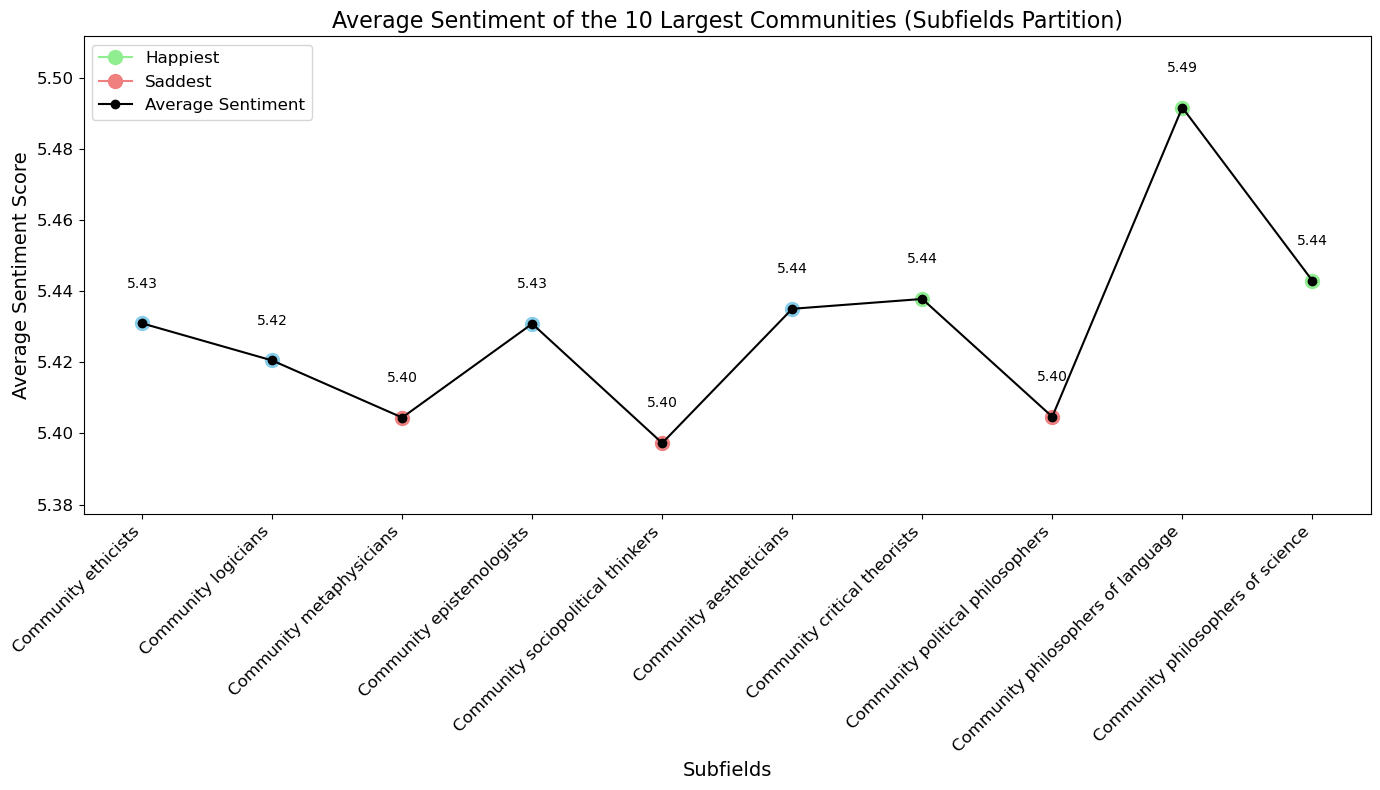

In [68]:
import matplotlib.pyplot as plt

# Prepare data for plotting
community_ids = [f"Community {c}" for c in largest_communities]
average_sentiments = [community_sentiments[c] for c in largest_communities]

# Assign colors based on sentiment
colors = []
for community_id in largest_communities:
    if community_id in [c[0] for c in happiest_communities]:
        colors.append('lightgreen')  # Happiest communities in green
    elif community_id in [c[0] for c in saddest_communities]:
        colors.append('lightcoral')  # Saddest communities in red
    else:
        colors.append('skyblue')  # Neutral color for other communities

# Create a line graph
plt.figure(figsize=(14, 8))  # Adjust figure size for better visibility

# Plot the main line
plt.plot(community_ids, average_sentiments, marker='o', color='black', linestyle='-', label='Average Sentiment')

# Highlight points with colored markers for happiest and saddest communities
for i, color in enumerate(colors):
    plt.scatter(community_ids[i], average_sentiments[i], color=color, s=100, label=None if color == 'skyblue' else f"{'Happiest' if color == 'lightgreen' else 'Saddest'}")

# Annotate points with sentiment values
for i, sentiment in enumerate(average_sentiments):
    plt.text(i, sentiment + 0.01, f"{sentiment:.2f}", ha='center', fontsize=10)

# Adjust the y-axis to focus on differences
plt.ylim(min(average_sentiments) - 0.02, max(average_sentiments) + 0.02)

# Label the axes and add a title
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Subfields", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.title("Average Sentiment of the 10 Largest Communities (Subfields Partition)", fontsize=16)

# Add legend for color-coded points
handles = [
    plt.Line2D([0], [0], color='lightgreen', marker='o', markersize=10, label='Happiest'),
    plt.Line2D([0], [0], color='lightcoral', marker='o', markersize=10, label='Saddest'),
    plt.Line2D([0], [0], color='black', marker='o', linestyle='-', label='Average Sentiment'),
]
plt.legend(handles=handles, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
